In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import (
    RandomForestClassifier,
    VotingClassifier,
    StackingClassifier,
)
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, train_test_split

from smoker_status.config import RAW_DATA_DIR
from smoker_status.features import create_encoded_X

In [3]:
df = pd.read_csv(RAW_DATA_DIR / 'train.csv')

df.head()

,id,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,...,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,smoking
0,0,55,165,60,81.0,0.5,0.6,1,1,135,...,40,75,16.5,1,1.0,22,25,27,0,1
1,1,70,165,65,89.0,0.6,0.7,2,2,146,...,57,126,16.2,1,1.1,27,23,37,1,0
2,2,20,170,75,81.0,0.4,0.5,1,1,118,...,45,93,17.4,1,0.8,27,31,53,0,1
3,3,35,180,95,105.0,1.5,1.2,1,1,131,...,38,102,15.9,1,1.0,20,27,30,1,0
4,4,30,165,60,80.5,1.5,1.0,1,1,121,...,44,93,15.4,1,0.8,19,13,17,0,1


In [4]:
X: pd.DataFrame = df.drop(['smoking', 'id'], axis=1)
y: pd.Series = df['smoking']

Looking at dataset, looks like the following features are classes:
`hearing(left)`, `hearing(right)`, `Urine protein`, `dental caries`

In [5]:
X_trans = create_encoded_X(X)
X_trans.head()

,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),systolic,relaxation,fasting blood sugar,Cholesterol,...,serum creatinine,AST,ALT,Gtp,hearing(left) - normal,hearing(left) - abnormal,hearing(right) - normal,hearing(right) - abnormal,dental caries - nonpresent,dental caries - present
0,55,165,60,81.0,0.5,0.6,135,87,94,172,...,1.0,22,25,27,1,0,1,0,1,0
1,70,165,65,89.0,0.6,0.7,146,83,147,194,...,1.1,27,23,37,0,1,0,1,0,1
2,20,170,75,81.0,0.4,0.5,118,75,79,178,...,0.8,27,31,53,1,0,1,0,1,0
3,35,180,95,105.0,1.5,1.2,131,88,91,180,...,1.0,20,27,30,1,0,1,0,0,1
4,30,165,60,80.5,1.5,1.0,121,76,91,155,...,0.8,19,13,17,1,0,1,0,1,0


Split into training and testing so we can play with accuracy_score() and predict()

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X_trans, y, test_size=0.3, random_state=1
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)

(111479, 25)
(111479,)
(47777, 25)
(47777,)


In [7]:
rf = RandomForestClassifier(n_estimators=100, random_state=1, n_jobs=-1)
lr = LogisticRegression()
dt = DecisionTreeClassifier(random_state=42)
knn = KNeighborsClassifier(n_neighbors=51, weights='uniform')

In [8]:
rf.fit(X_train, y_train)
lr.fit(X_train_scaled, y_train)
dt.fit(X_train, y_train)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=51)

In [9]:
voting = VotingClassifier(
    estimators=[('lr', lr), ('rf', rf), ('dt', dt), ('knn', knn)], voting='soft'
)
voting = voting.set_params(lr='drop')
voting = voting.fit(X_train_scaled, y_train)

scores = cross_val_score(voting, X_trans, y, cv=10, scoring='accuracy', n_jobs=-1)
scores.mean()

np.float64(0.7250339298849013)

In [10]:
y_predict = voting.predict(X_test)
print(accuracy_score(y_test, y_predict))

y_predict_prob = voting.predict_proba(X_test)
# Estimated likelihood of smoking=1 for testing set
print(y_predict_prob[:, 1])

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_predict_prob[:, 1], pos_label=1)
AUC = metrics.auc(fpr, tpr)
print(metrics.roc_auc_score(y_test, y_predict_prob[:, 1]))

/Users/user/Dev/smoker-status/.venv/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/user/Dev/smoker-status/.venv/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/Users/user/Dev/smoker-status/.venv/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


0.5597463214517445


/Users/user/Dev/smoker-status/.venv/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/user/Dev/smoker-status/.venv/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/Users/user/Dev/smoker-status/.venv/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


[0.37915033 0.41196078 0.39542484 ... 0.42156863 0.40542484 0.37607843]
0.6086568260444426


ROC Curve

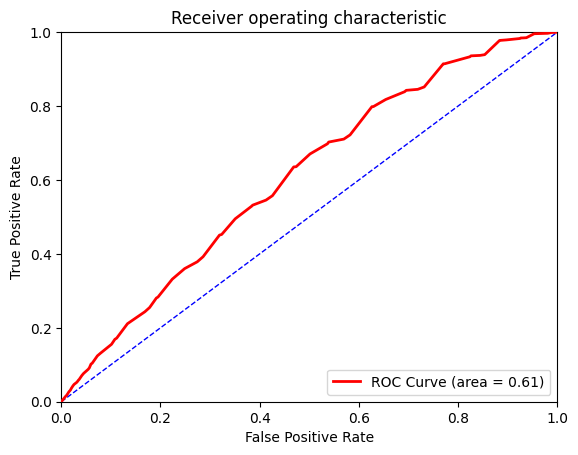

In [11]:
%matplotlib inline

plt.figure()

# Roc Curve:
plt.plot(fpr, tpr, color='red', lw=2, label=f'ROC Curve (area = {AUC:0.2f})', zorder=3)

# Random Guess line:
plt.plot([0, 1], [0, 1], color='blue', lw=1, linestyle='--')

# Defining The Range of X-Axis and Y-Axis:
plt.xlim([0, 1])
plt.ylim([0, 1])

# Labels, Title, Legend:
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc='lower right')

plt.show()

In [12]:
sc = StackingClassifier(
    estimators=[('rf', rf), ('dt', dt), ('knn', knn)],
    final_estimator=None,
)


stack = sc.fit(X_train, y_train)

# scores = cross_val_score(stack, X_trans, y, cv=10, scoring='accuracy', n_jobs=-1)
# scores.mean()

In [13]:
y_predict = stack.predict(X_test)
print(accuracy_score(y_test, y_predict))

y_predict_prob = stack.predict_proba(X_test)
# Estimated likelihood of smoking=1 for testing set
print(y_predict_prob[:, 1])

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_predict_prob[:, 1], pos_label=1)
AUC = metrics.auc(fpr, tpr)
print(metrics.roc_auc_score(y_test, y_predict_prob[:, 1]))

0.7765451995730163
[0.08971927 0.92318369 0.66687993 ... 0.89310576 0.35087718 0.04010246]
0.8587265107476003


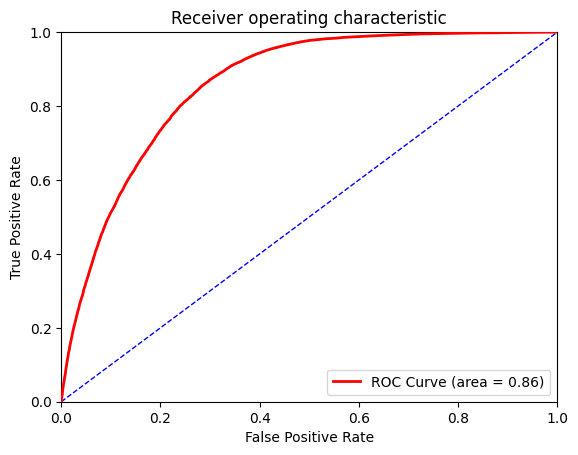

In [14]:
%matplotlib inline

plt.figure()

# Roc Curve:
plt.plot(fpr, tpr, color='red', lw=2, label=f'ROC Curve (area = {AUC:0.2f})', zorder=3)

# Random Guess line:
plt.plot([0, 1], [0, 1], color='blue', lw=1, linestyle='--')

# Defining The Range of X-Axis and Y-Axis:
plt.xlim([0, 1])
plt.ylim([0, 1])

# Labels, Title, Legend:
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc='lower right')

plt.show()